# Modeling and validation for CNN model and KMeans algorithm
[Data source](https://www.kaggle.com/datasets/shubhamgoel27/dermnet)

About Dataset
Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

Content
The images are in JPEG format, consisting of 3 channels, i.e. RGB. The resolutions vary from image to image, and from category to category, but overall these are not extremely high resolution imagery.

The categories include acne, melanoma, Eczema, Seborrheic Keratoses, Tinea Ringworm, Bullous disease, Poison Ivy, Psoriasis, Vascular Tumors, etc.

Acknowledgements
The images are taken from the public portal Dermnet (http://www.dermnet.com/) which is the largest dermatology source online built for the purpose of providing online medical education.

## Loading libraries

In [3]:
import os
import cv2
import random
import imageio
import zipfile
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from PIL import Image, ImageOps
from functools import partial
import SimpleITK as sitk
import scipy.ndimage as ndi
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance
from skimage import io, measure, morphology, data, exposure
from skimage.feature import canny, graycomatrix, graycoprops
from skimage.color import rgb2gray, label2rgb
from skimage.filters import gaussian, threshold_otsu, try_all_threshold
from skimage.segmentation import slic
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Input
from tensorflow.keras.datasets import cifar10
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AgglomerativeClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter("ignore")

# pip list --format=freeze > requirements.txt

## Used functions

In [ ]:
def add_padding_to_make_square(img):
    """
    Add padding to an image to make it square.
    """
    width, height = img.size
    if width == height:
        return img
    else:
        max_side = max(width, height)
        new_img = ImageOps.expand(img, (
            (max_side - width) // 2, 
            (max_side - height) // 2, 
            (max_side - width + 1) // 2, 
            (max_side - height + 1) // 2
        ), fill=(0, 0, 0))
        return new_img

def adjust_brightness(img, target_brightness):
    """
    Adjust the brightness of an image to match the target brightness.
    """
    grayscale_img = img.convert('L')
    img_array = np.array(grayscale_img)
    
    current_brightness = np.mean(img_array)
    brightness_factor = target_brightness / current_brightness
    
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array * brightness_factor
    
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    
    return Image.fromarray(img_array)

def normalize_images_brightness(images, target_brightness=None):
    """
    Normalize the brightness of all images to match the target brightness.
    """
    if target_brightness is None:
        total_brightness = 0
        for img in images:
            grayscale_img = img.convert('L')
            img_array = np.array(grayscale_img)
            total_brightness += np.mean(img_array)
        target_brightness = total_brightness / len(images)
    
    normalized_images = [adjust_brightness(img, target_brightness) for img in images]
    
    return normalized_images

def reduce_dimensions_pca(pca_components, features, do_plot=False):

    features = PCA(n_components=pca_components).fit_transform(features)

    pca = PCA().fit(features)

    if do_plot:
        plt.figure(figsize=(8,  4))
        plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance');
    
    return features

def metrics_plots(max_k, X):

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))
        print(f'{k} ', end='')

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def count_wcss_scores(X, k, model):
    #  WCSS = within-cluster sum of squares
    kmeans = model(n_clusters=k, random_state=0)
    kmeans.fit(X)
    return kmeans.score(X) * -1 # score returns -WCSS

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

def create_data_frame(max_parameter, features):

    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Example data to add row by row
    algorithms = {
        'Kmeans': KMeans
    }
    metrics = {
        'min dist between clusters': min_interclust_dist,
        'mean dist in clust': mean_inclust_dist,
        'std dev dist in clust': std_dev_of_inclust_dist,
        'mean dist to clust center': mean_dist_to_center,
        'silhouette': silhouette_score,
    }

    index = 0
    # Add rows to the DataFrame in a for loop
    for i, algorithm in enumerate(algorithms):
        print('{0: <33}'.format(f'{algorithm}')+'[-', end='')
        for cluster_num in range(2, max_parameter+1):
            print(f'{cluster_num}-', end='')
            df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
            df.loc[index, 'Feature_len'] = len(features[0])
            df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
            model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
            df.loc[index, 'WCSS'] = count_wcss_scores(features, cluster_num, algorithms[algorithm])
            index += 1
        print(']')
        
    return df

def plot_df(df):
    # List of metrics to plot
    metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette',
        'WCSS'
    ]

    # Set up the subplot grid (3 rows, 2 columns)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # Iterate over metrics and create a plot for each
    for i, metric in enumerate(metrics_vals):
        sns.lineplot(data=df, x='Parameters', y=metric, hue='Algorithm', marker='o', ax=axes[i])
        axes[i].set_title(f'{metric}')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Parameters')
        axes[i].legend(title='Algorithm')
        axes[i].grid(True)
    fig.suptitle('Clustering Performance Metrics vs Parameters', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
def plot_clusters(images, labels, num_clusters):
    plt.figure(figsize=(20, 20))
    for cluster in range(num_clusters):
        cluster_images = images[labels == cluster]
        for i in range(min(len(cluster_images), 10)):
            plt.subplot(num_clusters, 10, cluster * 10 + i + 1)
            plt.imshow(cluster_images[i])
            plt.axis('off')
    plt.show()

## Making a model

### Testing without standarization

In [4]:
# Load images from directory and pad them to be square, then resize to 32x32
data_dir = '../Data/train'
img_size = 32
images = []
for root, dirs, files in os.walk(data_dir):
    for file in files[:500]:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            img = Image.open(file_path)
            img = add_padding_to_make_square(img)
            img = img.resize((img_size, img_size))
            images.append(img)

# Normalize the brightness of all images
normalized_images = normalize_images_brightness(images)

# Convert normalized images to numpy array
images_array = np.array([np.array(img) / 255.0 for img in normalized_images])

print(f"Shape of the images array: {images_array.shape}")

Shape of the images array: (9957, 32, 32, 3)


In [5]:
# Define the autoencoder model
input_img = Input(shape=(img_size, img_size, 3))  # Adjust shape based on your images

# Feature layers to plot later
layers = []

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
layers.append(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
layers.append(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
layers.append(encoded)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
layers.append(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
layers.append(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
layers.append(decoded)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(images_array, images_array,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

# Create encoder model
encoder = Model(input_img, encoded)

# Extract features
features = encoder.predict(images_array)
features = features.reshape((features.shape[0], -1))  # Flatten the features for clustering
features_original = features.copy()

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - loss: 0.5882 - val_loss: 0.4414
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 0.4289 - val_loss: 0.4217
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 0.4160 - val_loss: 0.4172
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 0.4147 - val_loss: 0.4158
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.4099 - val_loss: 0.4135
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 0.4076 - val_loss: 0.4179
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.4073 - val_loss: 0.4092
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 0.4041 - val_loss: 0.4083
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 0.4026 - val_loss: 0.4075
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.4016 - val_loss: 0.4075
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.4024 - val_loss: 0.4066
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step

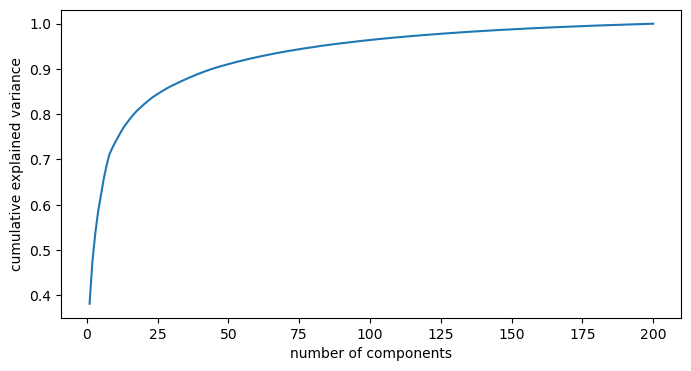

In [6]:
features = reduce_dimensions_pca(200, features_original, True)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

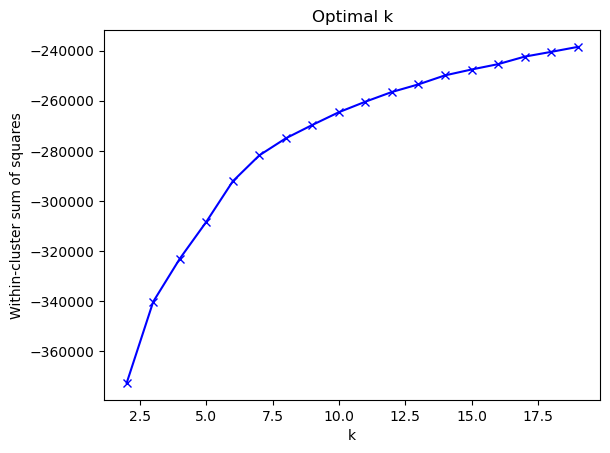

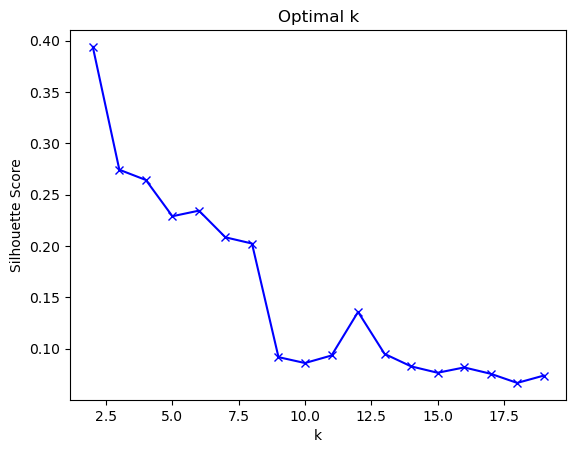

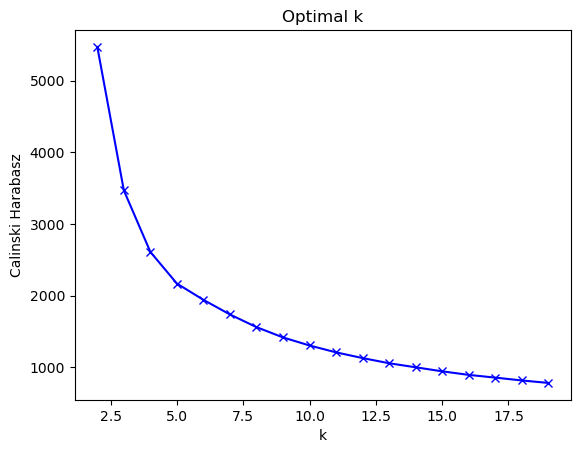

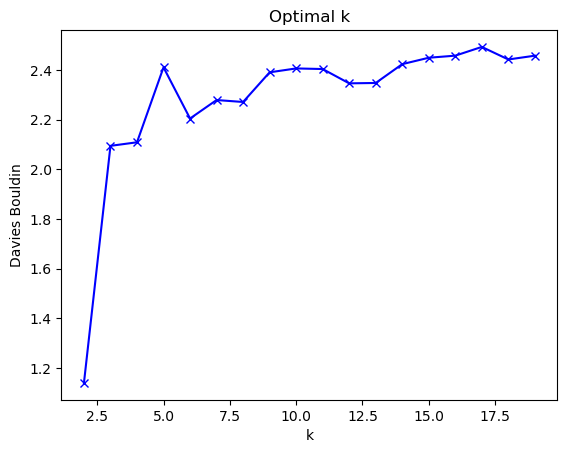

In [7]:
metrics_plots(20, features)

In [8]:
df = create_data_frame(25, features)
df.head()

Kmeans                           [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-]


Algorithm  Parameters  Feature_len  min dist between clusters  \
0    Kmeans         2.0        200.0                   2.008525   
1    Kmeans         3.0        200.0                   0.976366   
2    Kmeans         4.0        200.0                   0.041590   
3    Kmeans         5.0        200.0                   1.034665   
4    Kmeans         6.0        200.0                   1.034665   

   mean dist in clust  std dev dist in clust  mean dist to clust center  \
0            8.382941               0.500912                   5.826428   
1            8.467531               1.893383                   5.906646   
2            8.495167               1.755821                   5.921991   
3            8.102843               1.772385                   5.668155   
4            8.182763               1.908296                   5.729849   

   silhouette          WCSS  
0    0.393913  372563.40625  
1    0.274742  340165.56250  
2    0.264014  323046.59375  
3    0.243494  306287.87500  
4    0.217104  292137.31250

In [10]:
df

Algorithm  Parameters  Feature_len  min dist between clusters  \
0     Kmeans         2.0        200.0                   2.008525   
1     Kmeans         3.0        200.0                   0.976366   
2     Kmeans         4.0        200.0                   0.041590   
3     Kmeans         5.0        200.0                   1.034665   
4     Kmeans         6.0        200.0                   1.034665   
5     Kmeans         7.0        200.0                   1.034665   
6     Kmeans         8.0        200.0                   1.034665   
7     Kmeans         9.0        200.0                   0.946990   
8     Kmeans        10.0        200.0                   0.870044   
9     Kmeans        11.0        200.0                   0.792280   
10    Kmeans        12.0        200.0                   0.870044   
11    Kmeans        13.0        200.0                   0.462412   
12    Kmeans        14.0        200.0                   0.645918   
13    Kmeans        15.0        200.0                   0.645918   
14    Kmeans        16.0        200.0                   0.855661   
15    Kmeans        17.0        200.0                   0.667378   
16    Kmeans        18.0        200.0                   0.645918   
17    Kmeans        19.0        200.0                   0.855661   
18    Kmeans        20.0        200.0                   0.462412   
19    Kmeans        21.0        200.0                   0.645918   
20    Kmeans        22.0        200.0                   0.645918   
21    Kmeans        23.0        200.0                   0.599444   
22    Kmeans        24.0        200.0                   0.587843   
23    Kmeans        25.0        200.0                   0.337539   

    mean dist in clust  std dev dist in clust  mean dist to clust center  \
0             8.382941               0.500912                   5.826428   
1             8.467531               1.893383                   5.906646   
2             8.495167               1.755821                   5.921991   
3             8.102843               1.772385                   5.668155   
4             8.182763               1.908296                   5.729849   
5             8.086576               1.835682                   5.661364   
6             8.103937               1.784103                   5.673912   
7             8.095790               1.711496                   5.697511   
8             7.854003               1.963537                   5.666797   
9             7.872533               1.967841                   5.540334   
10            7.782405               1.893583                   5.448432   
11            7.780576               1.896084                   5.438266   
12            7.790921               1.999730                   5.498151   
13            7.761046               1.959094                   5.446890   
14            7.808712               1.933277                   5.449212   
15            7.722252               1.895640                   5.475486   
16            7.728496               1.867127                   5.398421   
17            7.649911               2.004046                   5.333961   
18            7.768308               1.885764                   5.356552   
19            7.768305               2.049826                   5.371760   
20            7.785791               2.043877                   5.407075   
21            7.649905               2.019581                   5.428472   
22            7.576685               1.879328                   5.324595   
23            7.719133               1.997013                   5.413301   

    silhouette           WCSS  
0     0.393913  372563.406250  
1     0.274742  340165.562500  
2     0.264014  323046.593750  
3     0.243494  306287.875000  
4     0.217104  292137.312500  
5     0.209174  281801.375000  
6     0.203067  274999.781250  
7     0.201300  269352.812500  
8     0.163428  264292.625000  
9     0.150784  260303.750000  
10    0.141528  256540.000000  
11    0.084341  2

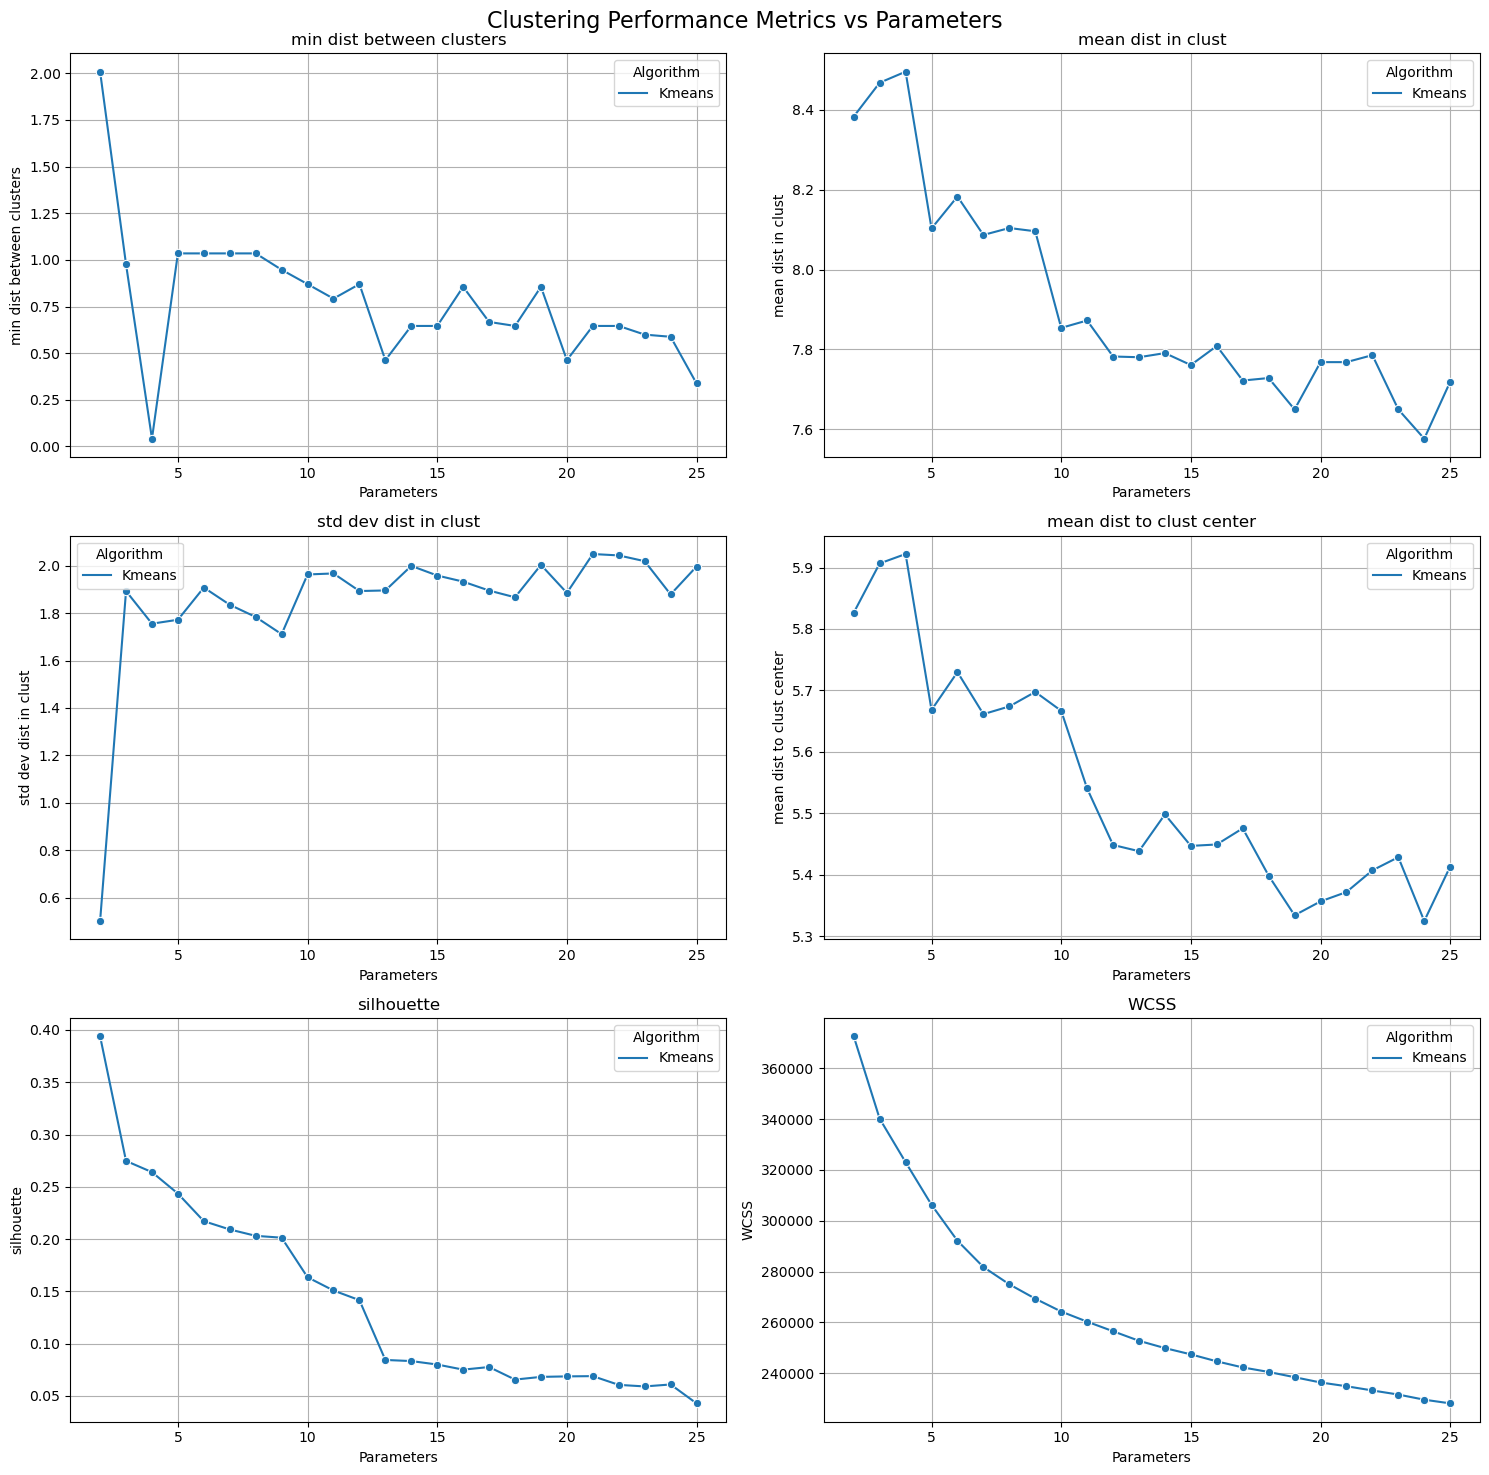

In [11]:
plot_df(df)

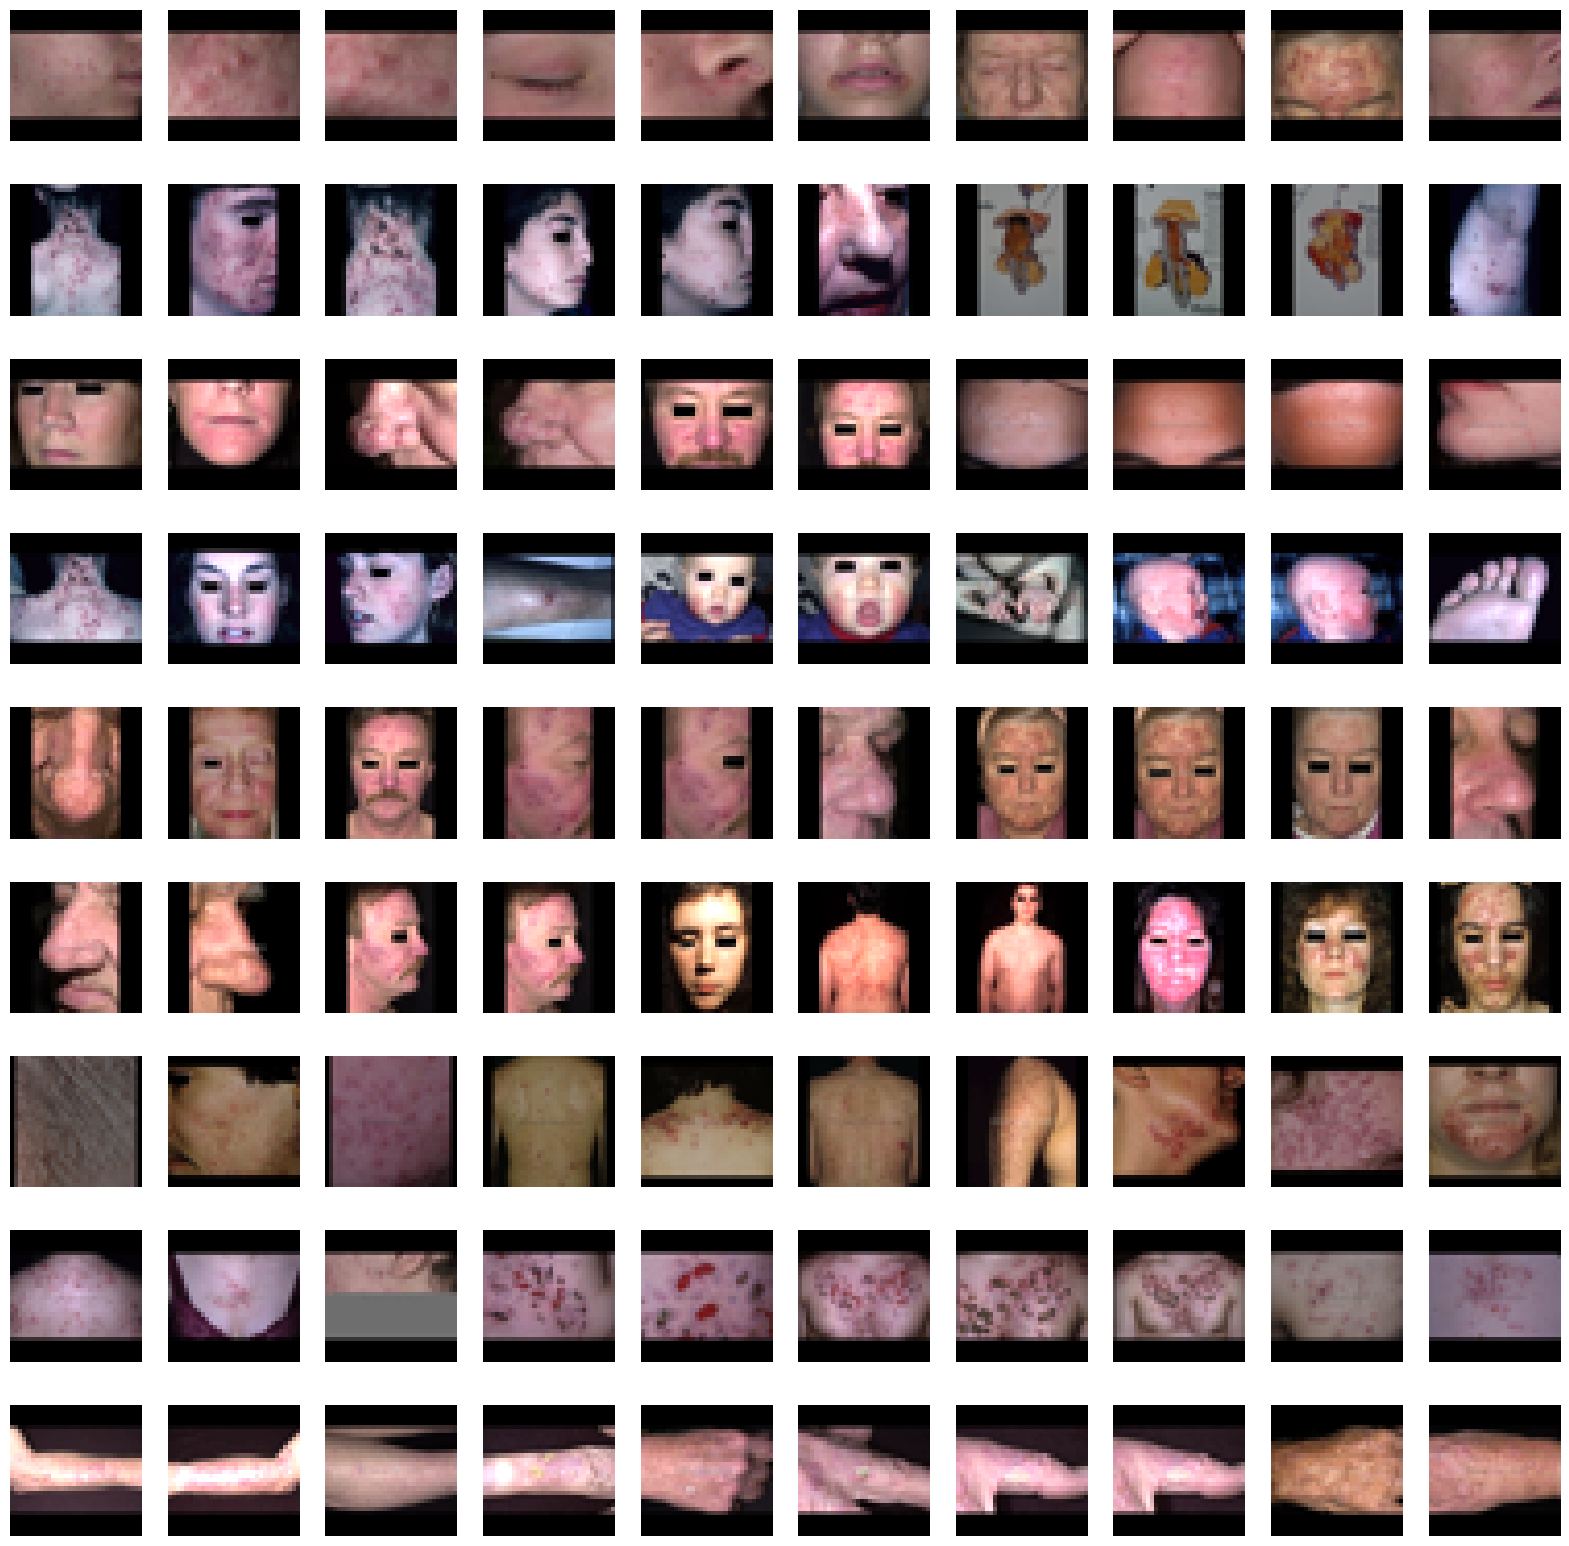

In [13]:
# Define the number of clusters
num_clusters = 9  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

plot_clusters(images_array, clusters, num_clusters)

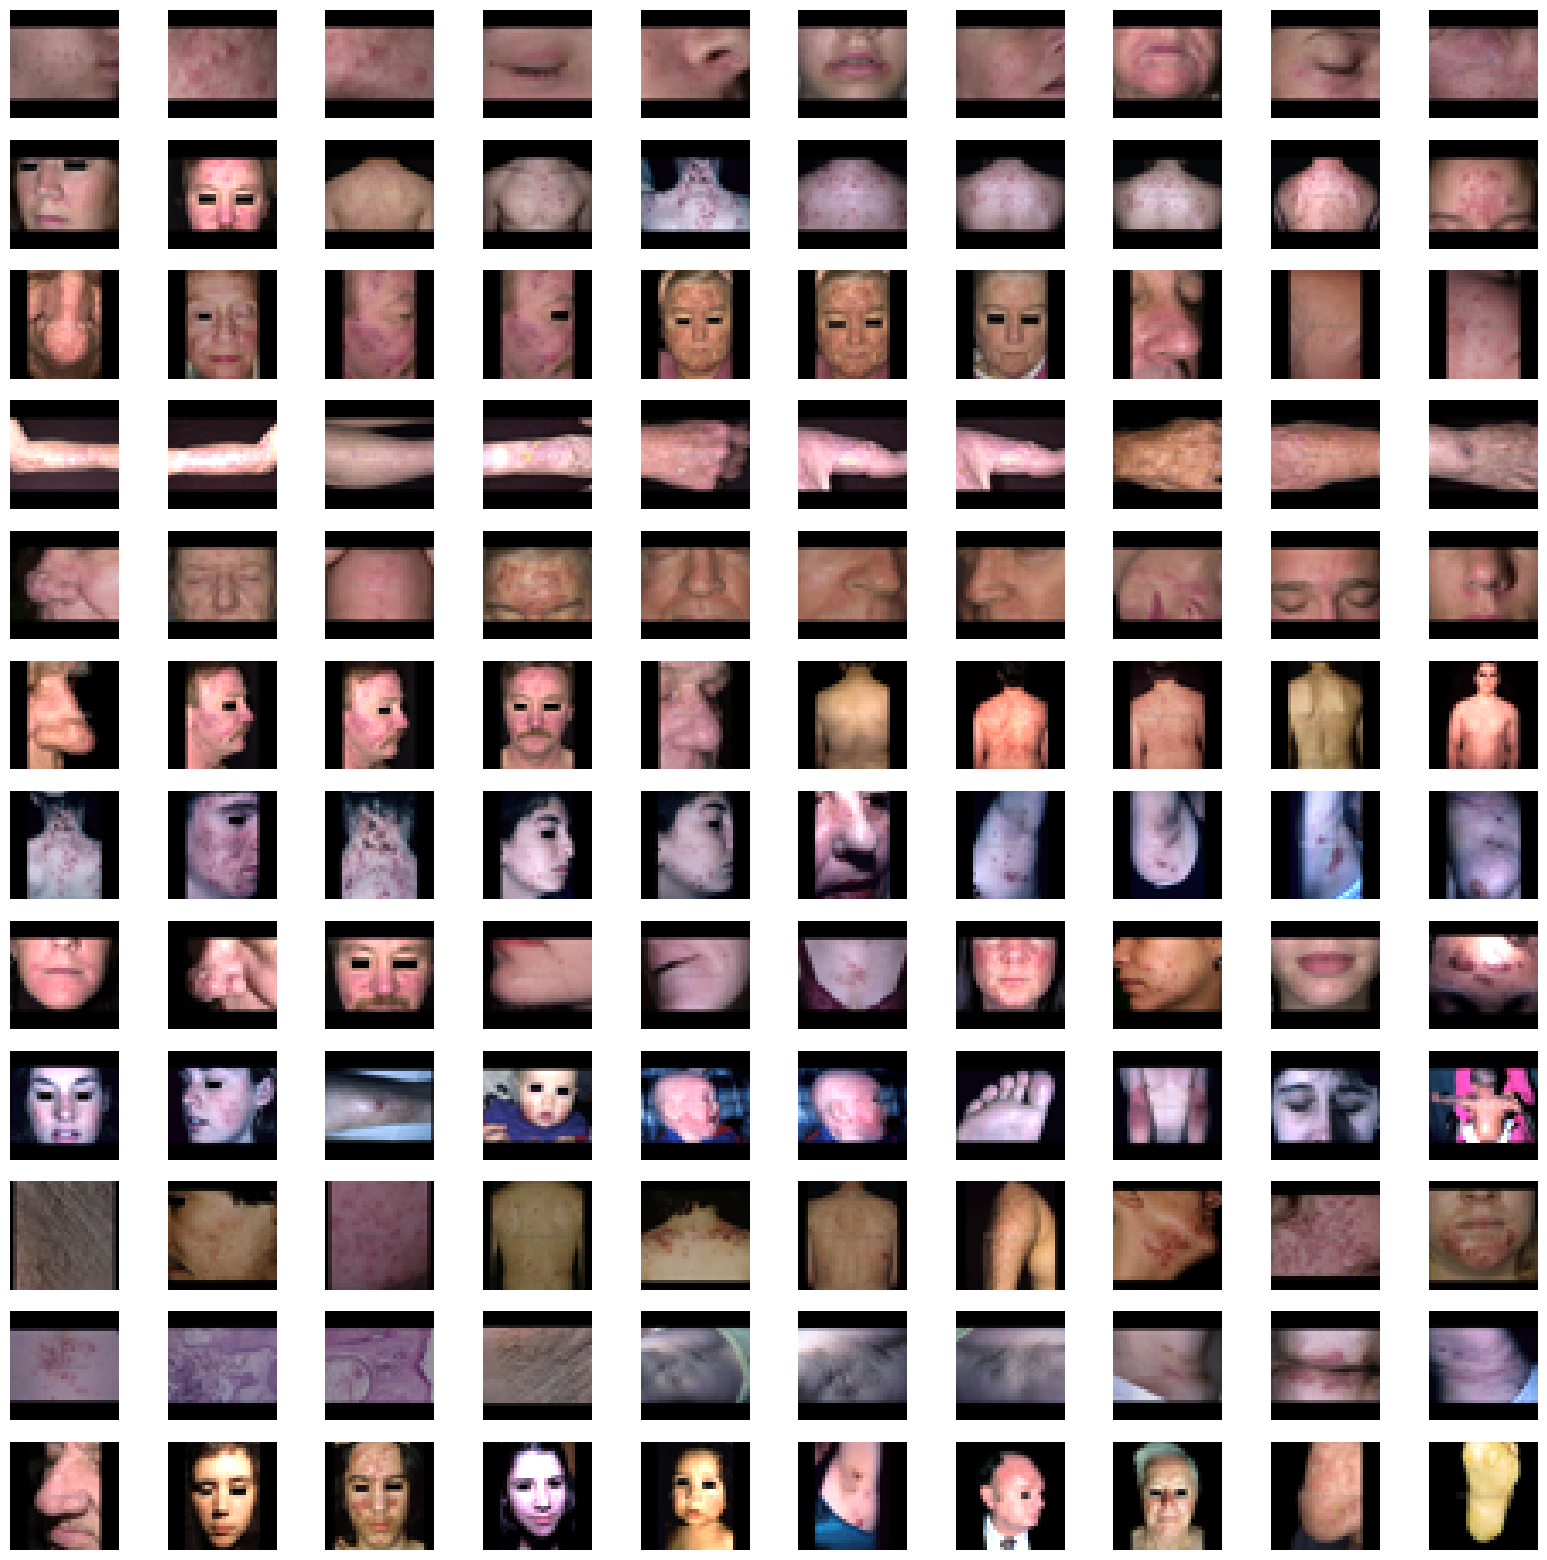

In [12]:
# Define the number of clusters
num_clusters = 12  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

plot_clusters(images_array, clusters, num_clusters)

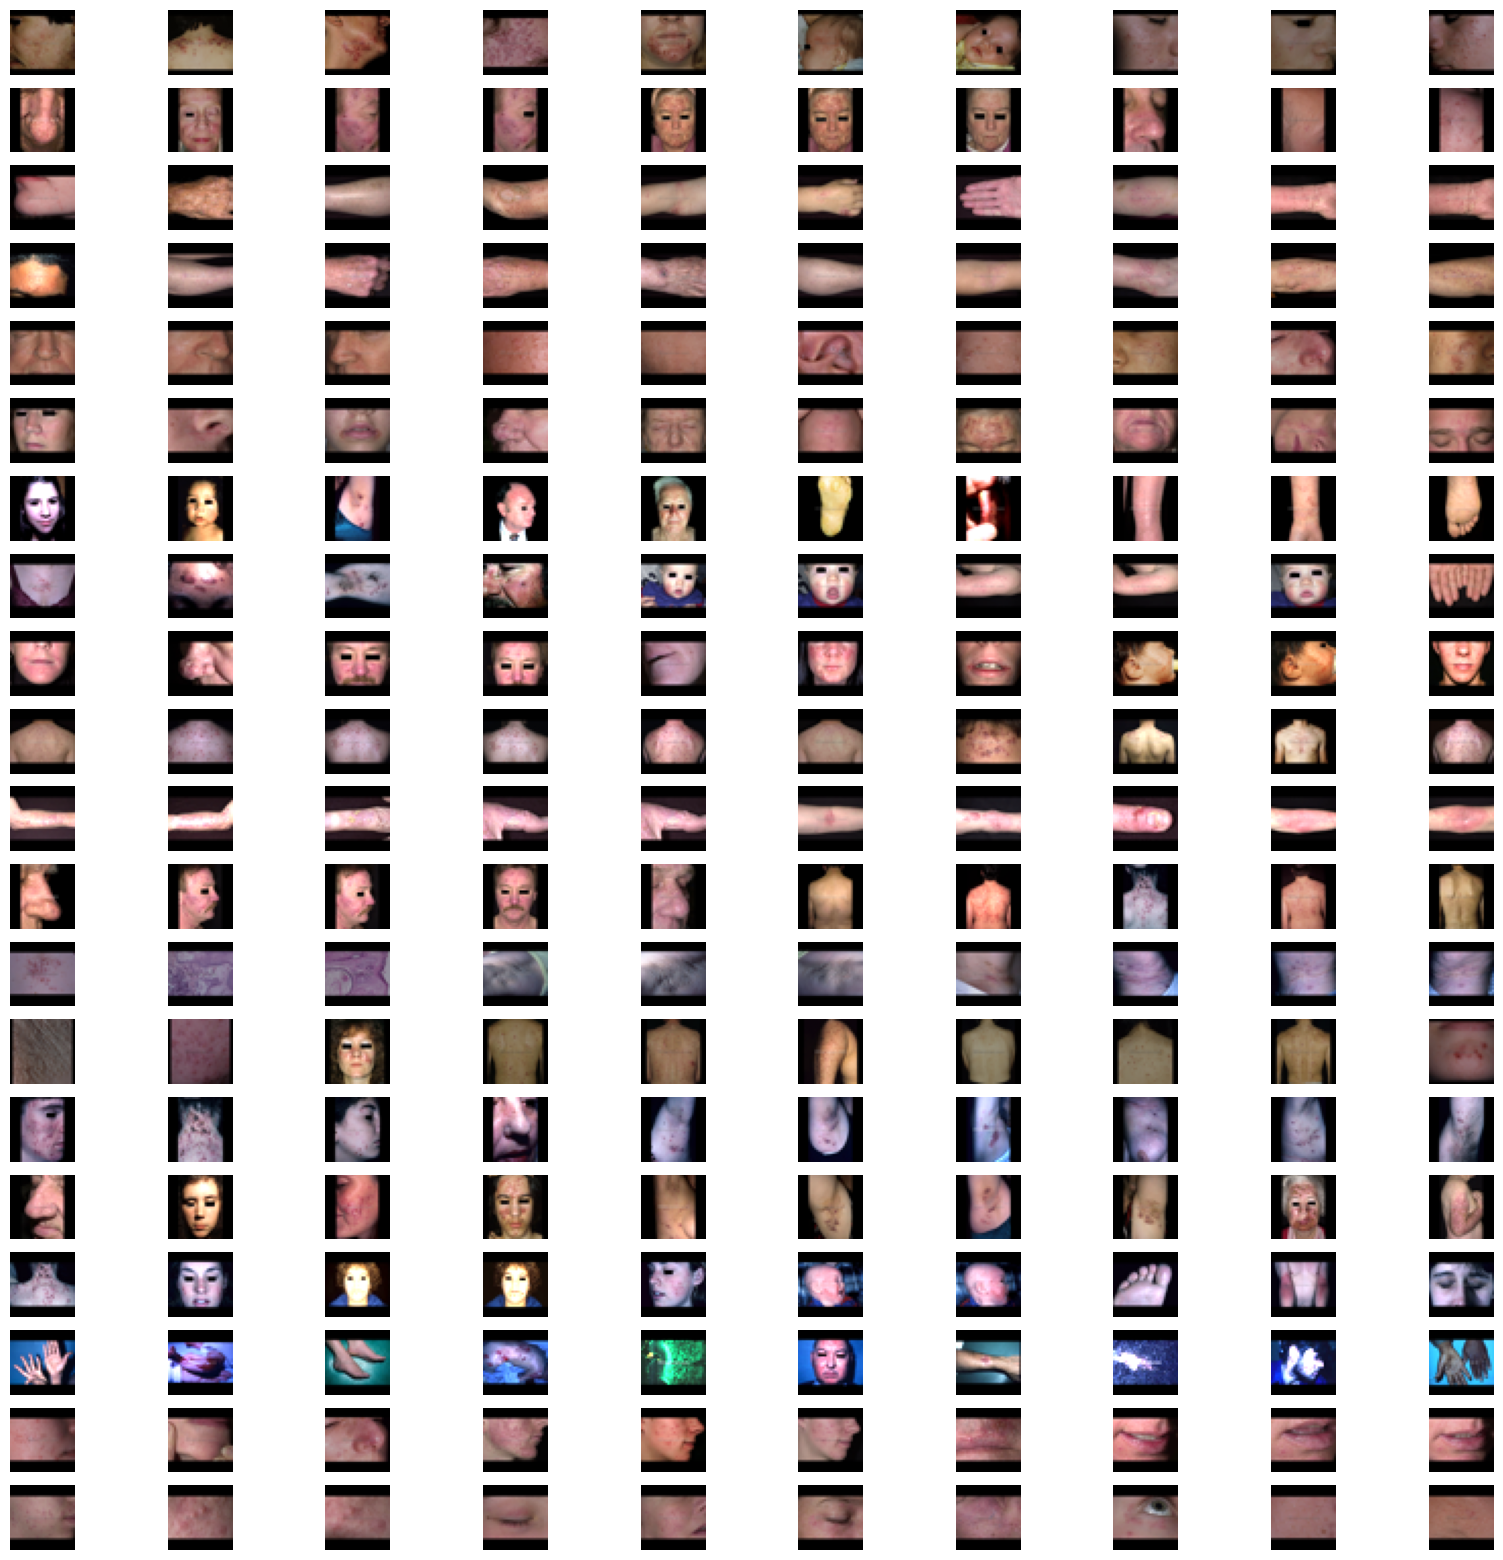

In [14]:
# Define the number of clusters
num_clusters = 20  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

plot_clusters(images_array, clusters, num_clusters)

### Testing with standarization

In [15]:
scaler = StandardScaler()
scaler.fit(features_original)
features_original = scaler.transform(features_original)
features = features_original.copy()

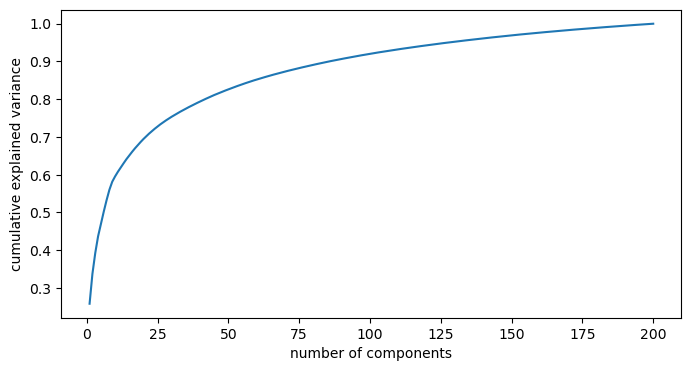

In [16]:
features = reduce_dimensions_pca(200, features_original, True)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

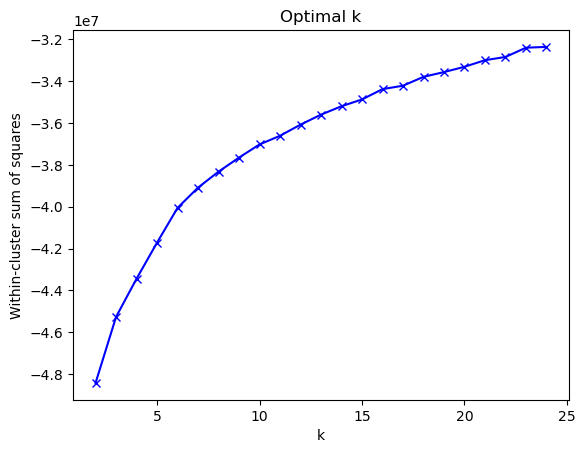

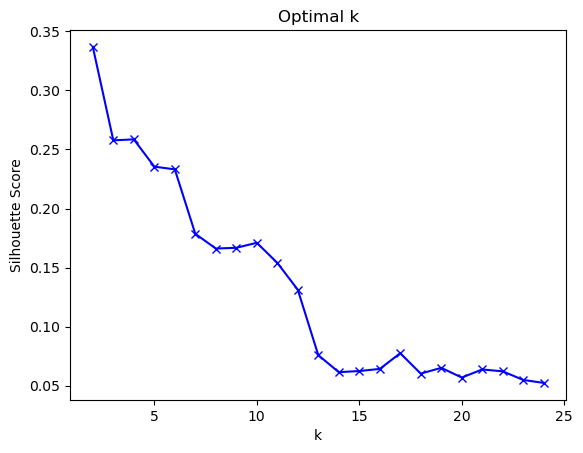

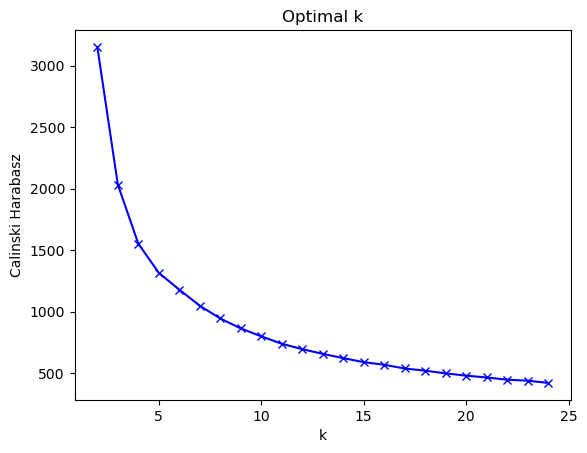

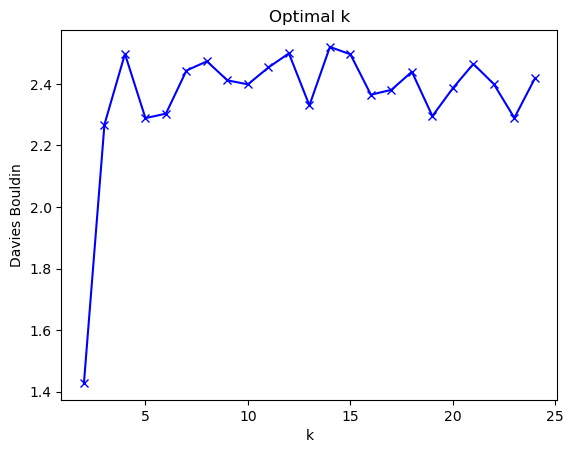

In [17]:
metrics_plots(25, features)

In [18]:
df = create_data_frame(25, features)
df.head()

Kmeans                           [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-]


Algorithm  Parameters  Feature_len  min dist between clusters  \
0    Kmeans         2.0        200.0                  18.078519   
1    Kmeans         3.0        200.0                  13.763616   
2    Kmeans         4.0        200.0                  13.763616   
3    Kmeans         5.0        200.0                  16.394623   
4    Kmeans         6.0        200.0                  13.173648   

   mean dist in clust  std dev dist in clust  mean dist to clust center  \
0           92.341226               9.231294                  63.334839   
1           94.914169              22.302865                  65.244895   
2          101.757921              30.258028                  69.965788   
3          100.255594              29.518204                  66.420217   
4           95.803488              27.772100                  66.011117   

   silhouette        WCSS  
0    0.336886  48418448.0  
1    0.257754  45262168.0  
2    0.258569  43436868.0  
3    0.235611  41712188.0  
4    0.233227  40051416.0

In [19]:
df

Algorithm  Parameters  Feature_len  min dist between clusters  \
0     Kmeans         2.0        200.0                  18.078519   
1     Kmeans         3.0        200.0                  13.763616   
2     Kmeans         4.0        200.0                  13.763616   
3     Kmeans         5.0        200.0                  16.394623   
4     Kmeans         6.0        200.0                  13.173648   
5     Kmeans         7.0        200.0                  13.173648   
6     Kmeans         8.0        200.0                  13.173648   
7     Kmeans         9.0        200.0                  13.173648   
8     Kmeans        10.0        200.0                  11.375018   
9     Kmeans        11.0        200.0                   4.912380   
10    Kmeans        12.0        200.0                  11.375018   
11    Kmeans        13.0        200.0                   6.273706   
12    Kmeans        14.0        200.0                   6.273706   
13    Kmeans        15.0        200.0                   4.499837   
14    Kmeans        16.0        200.0                   6.705643   
15    Kmeans        17.0        200.0                   6.457724   
16    Kmeans        18.0        200.0                   7.422910   
17    Kmeans        19.0        200.0                   4.497095   
18    Kmeans        20.0        200.0                   4.912380   
19    Kmeans        21.0        200.0                   7.422910   
20    Kmeans        22.0        200.0                   3.704696   
21    Kmeans        23.0        200.0                   3.704696   
22    Kmeans        24.0        200.0                   3.704696   
23    Kmeans        25.0        200.0                   7.422910   

    mean dist in clust  std dev dist in clust  mean dist to clust center  \
0            92.341226               9.231294                  63.334839   
1            94.914169              22.302865                  65.244895   
2           101.757921              30.258028                  69.965788   
3           100.255594              29.518204                  66.420217   
4            95.803488              27.772100                  66.011117   
5            93.474682              27.441239                  64.448421   
6            93.678564              27.793023                  64.668831   
7           117.613003              95.766351                  83.225421   
8           149.555483              88.677730                  86.040457   
9           109.384729              78.718812                  84.197865   
10                 NaN             121.674067                  91.480995   
11          125.382113              89.335916                  83.150585   
12          117.770394             119.163140                  95.300360   
13          126.451642                    NaN                  75.444089   
14          129.598070              88.718927                  80.361462   
15                 NaN                    NaN                  85.195469   
16                 NaN                    NaN                  83.799620   
17                 NaN                    NaN                  78.502783   
18                 NaN                    NaN                  96.476884   
19                 NaN                    NaN                  73.248126   
20                 NaN                    NaN                  70.870598   
21                 NaN                    NaN                  85.856875   
22                 NaN                    NaN                  71.525375   
23                 NaN                    NaN                  70.124031   

    silhouette        WCSS  
0     0.336886  48418448.0  
1     0.257754  45262168.0  
2     0.258569  43436868.0  
3     0.235611  41712188.0  
4     0.233227  40051416.0  
5     0.177915  39084440.0  
6     0.167213  38320552.0  
7     0.167159  37626448.0  
8     0.164910  37042452.0  
9     0.170065  36557352.0  
10    0.137373  36103608.0  
11    0.057776  35603340.0  
12    0.078138  35202004

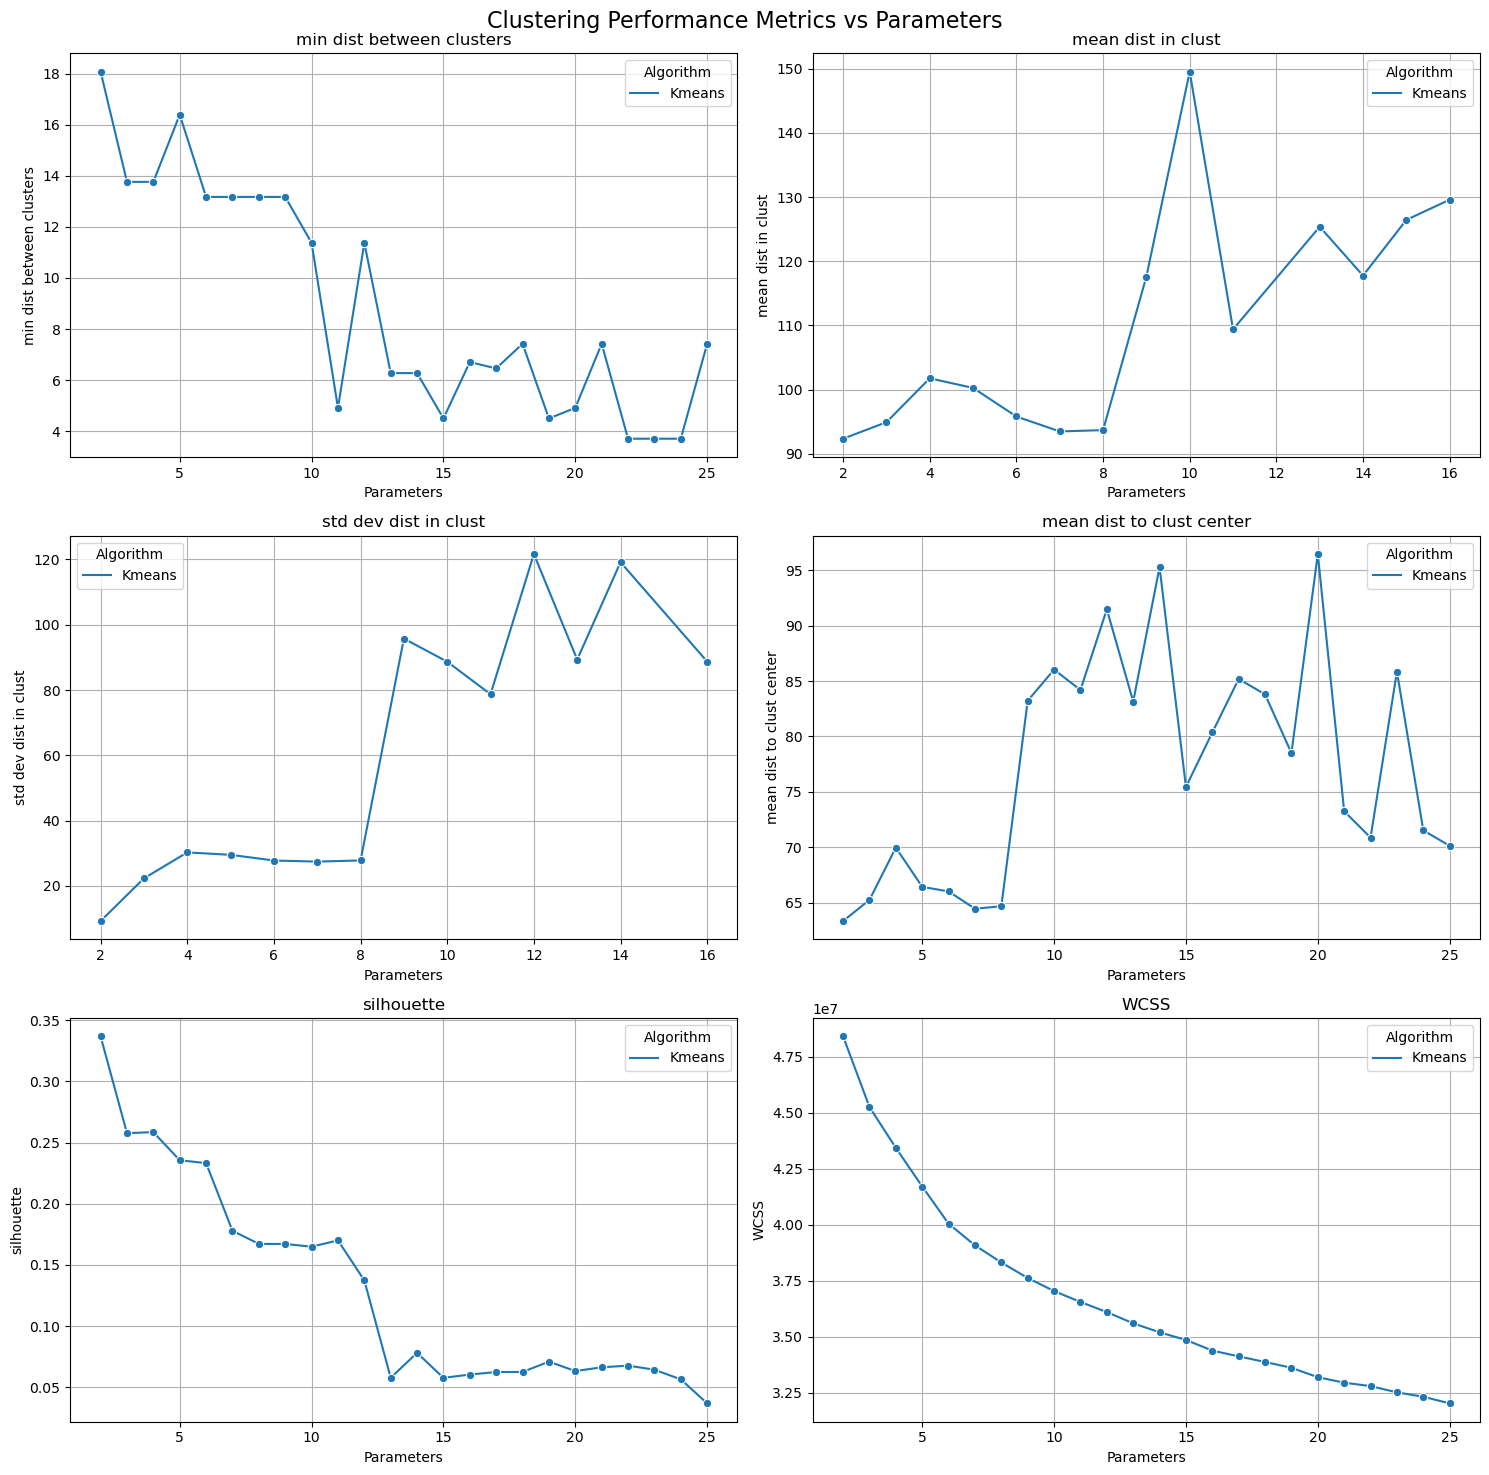

In [20]:
plot_df(df)

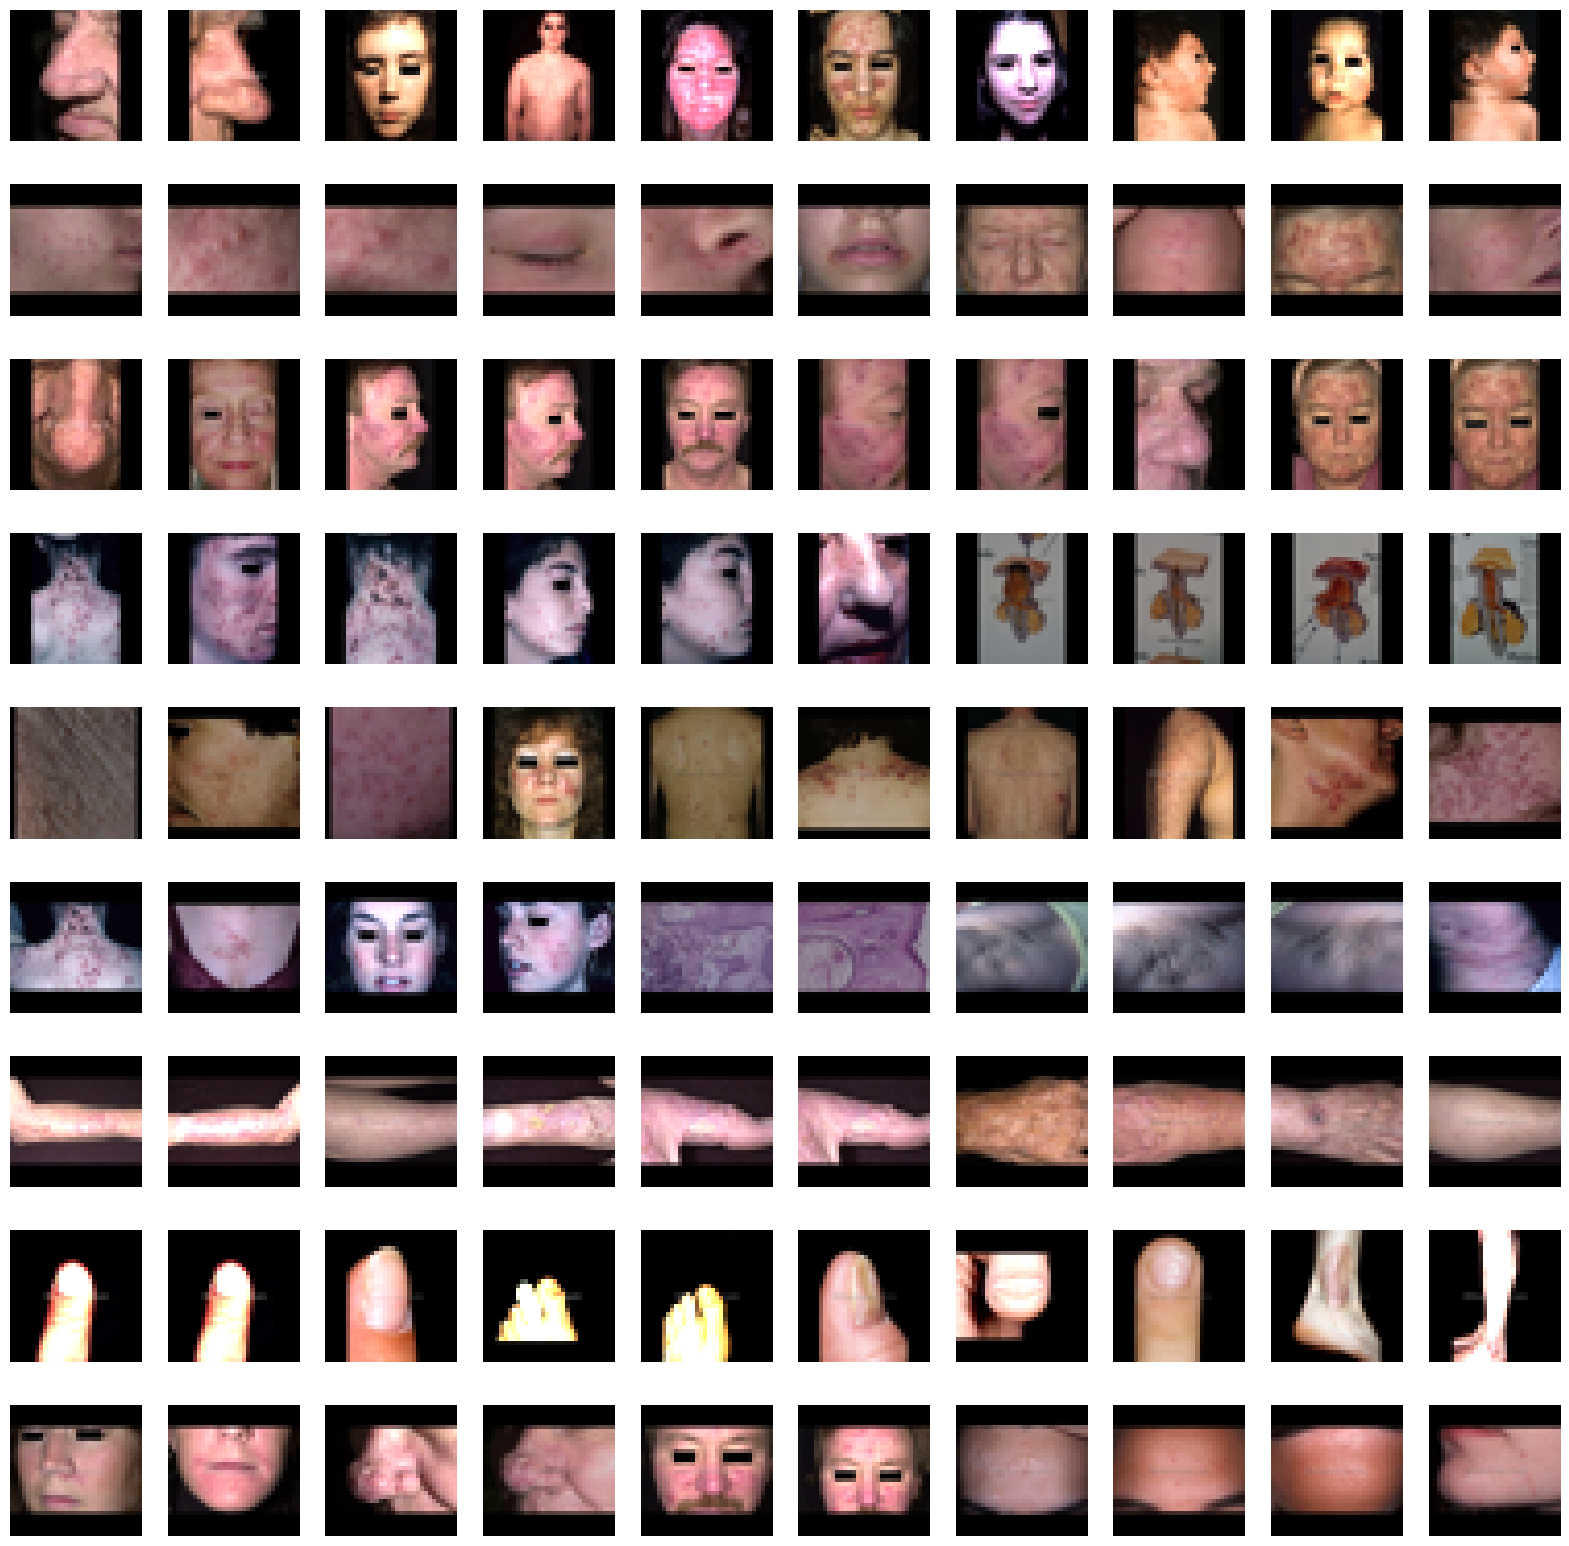

In [24]:
# Define the number of clusters
num_clusters = 9  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

plot_clusters(images_array, clusters, num_clusters)

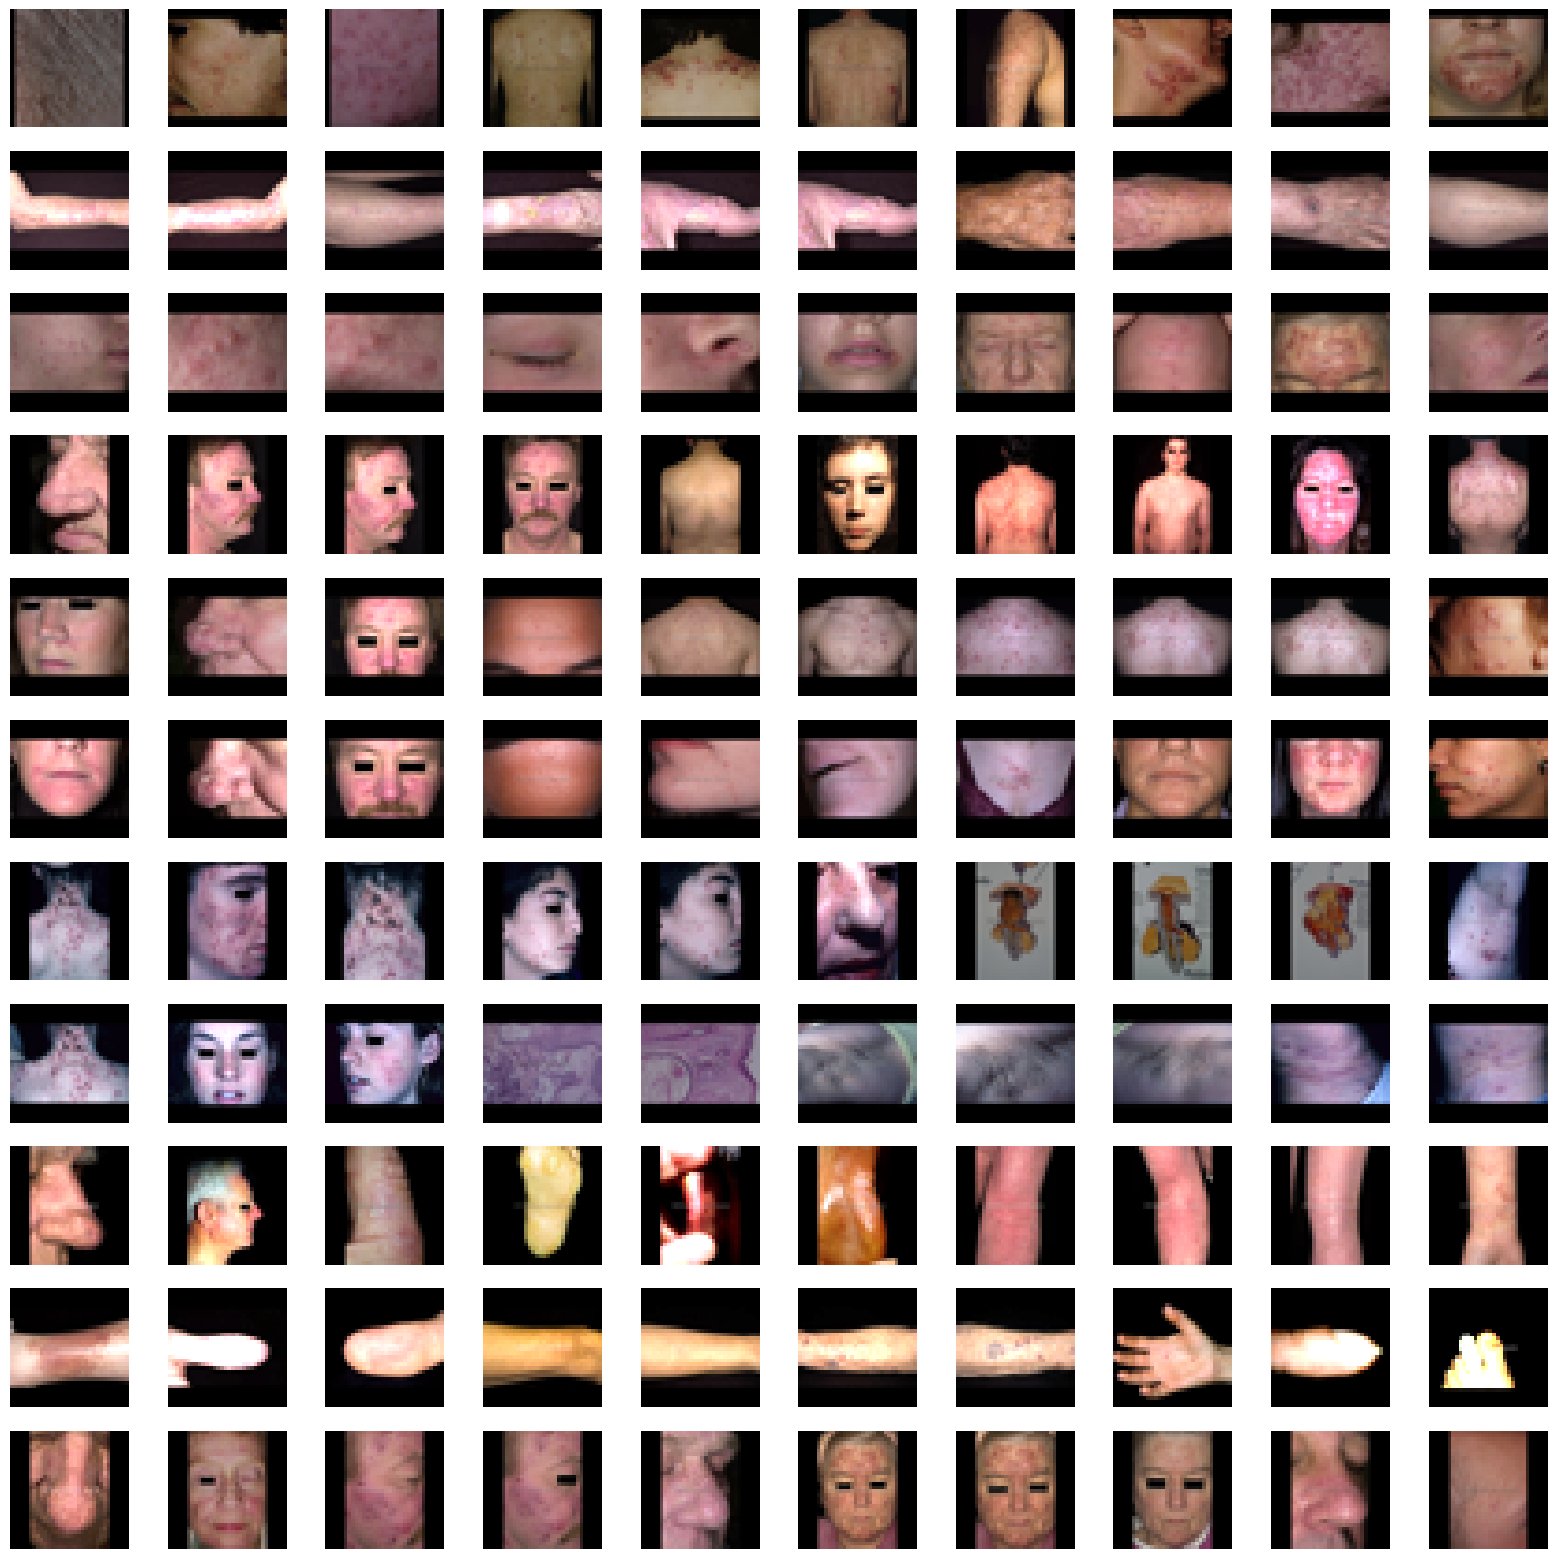

In [21]:
# Define the number of clusters
num_clusters = 11  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

plot_clusters(images_array, clusters, num_clusters)

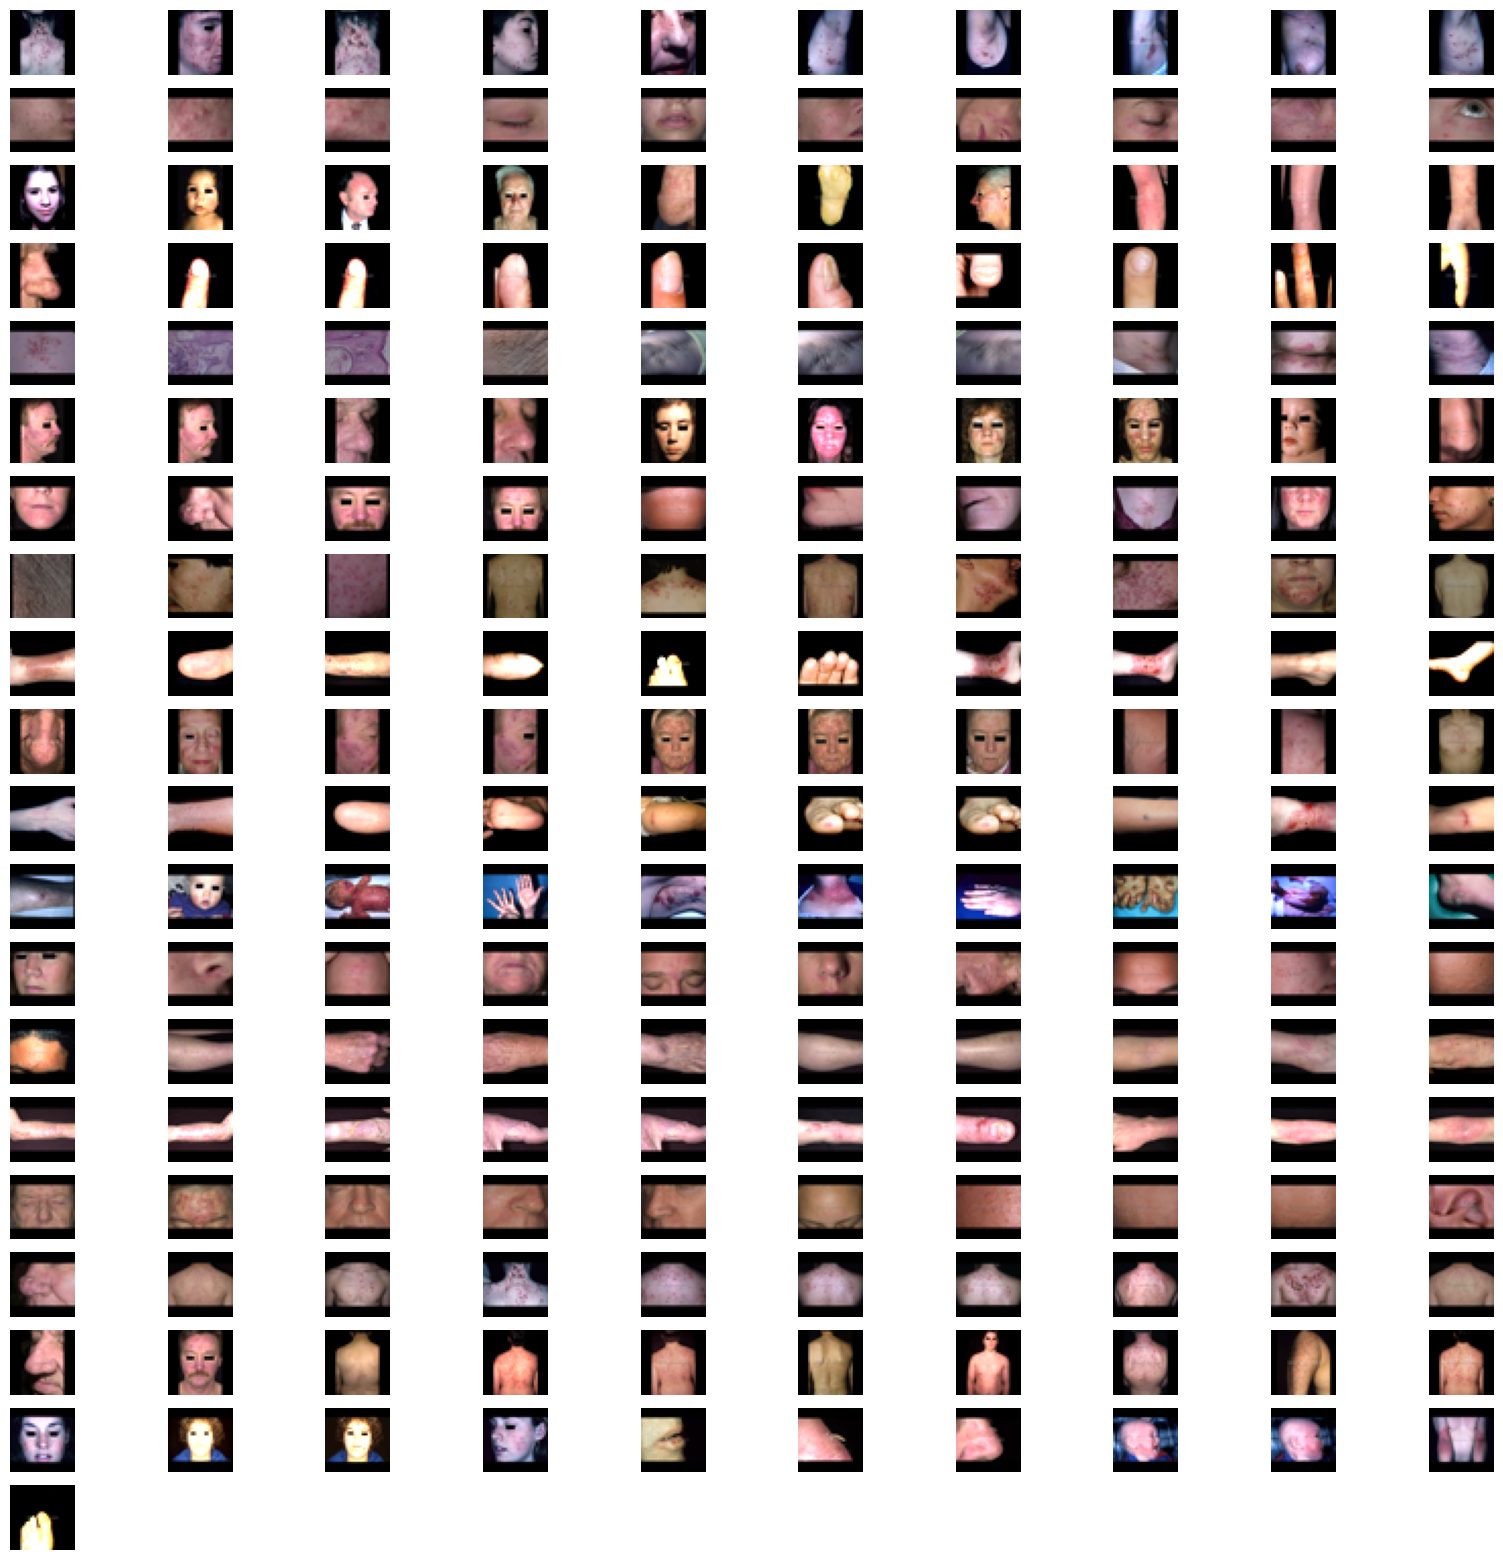

In [22]:
# Define the number of clusters
num_clusters = 20  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

plot_clusters(images_array, clusters, num_clusters)

# Final note

Best performing model was KMeans using features extracted from CNN.

Images' brightness was adjusted and a zero-padding was added to make them square.

Standarizatiion worsened the results. 

Dimensions were reduced with PCA with 200 components.

Metrics:\
Clulsters 12.0
Feature_len	min dist between clusters 0.870044
mean dist in clust 7.782405
std dev dist in clust 1.893583
mean dist to clust center 5.448432
silhouette 0.141528
WCSS 256540.000000					

# Finished  model pipeline

In [13]:
def CNN_KMeans_clusters(path, limiting=0, clusters_num=12):

    def add_padding_to_make_square(img):
        """
        Add padding to an image to make it square.
        """
        width, height = img.size
        if width == height:
            return img
        else:
            max_side = max(width, height)
            new_img = ImageOps.expand(img, (
                (max_side - width) // 2, 
                (max_side - height) // 2, 
                (max_side - width + 1) // 2, 
                (max_side - height + 1) // 2
            ), fill=(0, 0, 0))
            return new_img

    def adjust_brightness(img, target_brightness):
        """
        Adjust the brightness of an image to match the target brightness.
        """
        grayscale_img = img.convert('L')
        img_array = np.array(grayscale_img)

        current_brightness = np.mean(img_array)
        brightness_factor = target_brightness / current_brightness

        img_array = np.array(img, dtype=np.float32)
        img_array = img_array * brightness_factor

        img_array = np.clip(img_array, 0, 255).astype(np.uint8)

        return Image.fromarray(img_array)

    def normalize_images_brightness(images, target_brightness=None):
        """
        Normalize the brightness of all images to match the target brightness.
        """
        if target_brightness is None:
            total_brightness = 0
            for img in images:
                grayscale_img = img.convert('L')
                img_array = np.array(grayscale_img)
                total_brightness += np.mean(img_array)
            target_brightness = total_brightness / len(images)

        normalized_images = [adjust_brightness(img, target_brightness) for img in images]

        return normalized_images
    
    def reduce_dimensions_pca(pca_components, features):

        features = PCA(n_components=pca_components).fit_transform(features)

        pca = PCA().fit(features)

        return features

    # Load images from directory and pad them to be square, then resize to 32x32
    data_dir = path
    img_size = 32
    images = []
    if limiting==0:
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.jpg'):
                    file_path = os.path.join(root, file)
                    img = Image.open(file_path)
                    img = add_padding_to_make_square(img)
                    img = img.resize((img_size, img_size))
                    images.append(img)
    else:
        for root, dirs, files in os.walk(data_dir):
            for file in files[:limiting]:
                if file.endswith('.jpg'):
                    file_path = os.path.join(root, file)
                    img = Image.open(file_path)
                    img = add_padding_to_make_square(img)
                    img = img.resize((img_size, img_size))
                    images.append(img)

    # Normalize the brightness of all images
    normalized_images = normalize_images_brightness(images)

    # Convert normalized images to numpy array
    images_array = np.array([np.array(img) / 255.0 for img in images])
    
    # Define the autoencoder model
    input_img = Input(shape=(img_size, img_size, 3))  # Adjust shape based on your images

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    # Train the autoencoder
    autoencoder.fit(images_array, images_array,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.2)

    # Create encoder model
    encoder = Model(input_img, encoded)

    # Extract features
    features = encoder.predict(images_array)
    features = features.reshape((features.shape[0], -1))  # Flatten the features for clustering

    # PCA dimensionality reduction
    features = reduce_dimensions_pca(200, features)
    
    # Define the number of clusters
    num_clusters = clusters_num

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    return images_array, clusters, num_clusters

def plot_clusters(images, labels, num_clusters):
    plt.figure(figsize=(20, 20))
    for cluster in range(num_clusters):
        cluster_images = images[labels == cluster]
        for i in range(min(len(cluster_images), 10)):
            plt.subplot(num_clusters, 10, cluster * 10 + i + 1)
            plt.imshow(cluster_images[i])
            plt.axis('off')
    plt.show()

In [14]:
# Example of usage
# Inputs:
# 1) Provide the function with a path to images (all subdirectories will be searched).
# 2) The number of images taken from each subdirectory. Value 0 means all images will be read. (deefault=0)
# Outputs:
# 1) An array of images.
# 2) Created clusters.
# 3) Number of created clusters.
images_array, clusters, num_clusters = CNN_KMeans_clusters('../Data/train', limiting=500)

In [15]:
# Function below plots created clusters.
# Each row is a cluster with sample images.
plot_clusters(images_array, clusters, num_clusters)